In [1]:
# To obtain reproducible results
import sys
sys.path.insert(0, '/home/abanihi/devel/myprojects/deep-learning/')
from utils import reproducibility
from keras import layers
from keras import models
from keras import regularizers
from keras import losses
from keras import callbacks
from keras import backend as K
import tensorflow as tf
from math import sqrt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import numpy as np

/home/abanihi/anaconda3/envs/autoe/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the data

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train.shape, x_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

# Normalize and flatten the data

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [5]:
x_train.shape, x_test.shape

((50000, 3072), (10000, 3072))

In [6]:
# This is the size of our encoded representations
encoding_dim = 108

In [7]:
# this is our input placeholder
image_dim = x_train.shape[1]
input_img = layers.Input(shape=(image_dim, ))

In [8]:
# encoded is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)

In [9]:
# decoded is the lossy reconstruction of the input
decoded = layers.Dense(image_dim, activation='sigmoid')(encoded)

In [10]:
# This model maps an input to its reconstruction
autoencoder = models.Model(input_img, decoded)

In [11]:
# This model maps an input to its encoded representation
encoder = models.Model(input_img, encoded)

In [12]:
# Create a placeholder for an encoded (128-dimensional) input
encoded_input = layers.Input(shape=(encoding_dim, ))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = models.Model(encoded_input, decoder_layer(encoded_input))

In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 108)               331884    
Total params: 331,884
Trainable params: 331,884
Non-trainable params: 0
_________________________________________________________________


In [14]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 108)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              334848    
Total params: 334,848
Trainable params: 334,848
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 108)               331884    
_________________________________________________________________
dense_2 (Dense)              (None, 3072)              334848    
Total params: 666,732
Trainable params: 666,732
Non-trainable params: 0
_________________________________________________________________


In [16]:
from keras_sequential_ascii import sequential_model_to_ascii_printout

In [17]:
sequential_model_to_ascii_printout(autoencoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        3072
          InputLayer     |   -------------------         0     0.0%
                       #####        3072
               Dense   XXXXX -------------------    331884    49.8%
                relu   #####         108
               Dense   XXXXX -------------------    334848    50.2%
             sigmoid   #####        3072


In [18]:
sequential_model_to_ascii_printout(encoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####        3072
          InputLayer     |   -------------------         0     0.0%
                       #####        3072
               Dense   XXXXX -------------------    331884   100.0%
                relu   #####         108


In [19]:
sequential_model_to_ascii_printout(decoder)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####         108
          InputLayer     |   -------------------         0     0.0%
                       #####         108
               Dense   XXXXX -------------------    334848   100.0%
             sigmoid   #####        3072


# Train

In [20]:
callbacks_list = [callbacks.EarlyStopping(monitor='loss', patience=5)]

In [21]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [22]:
%%time 
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 217us/step - loss: 0.6928 - val_loss: 0.6919
Epoch 2/50
50000/50000 [==============================] - 10s 202us/step - loss: 0.6887 - val_loss: 0.6837
Epoch 3/50
50000/50000 [==============================] - 10s 204us/step - loss: 0.6788 - val_loss: 0.6744
Epoch 4/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.6700 - val_loss: 0.6652
Epoch 5/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.6608 - val_loss: 0.6566
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.6538 - val_loss: 0.6513
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.6495 - val_loss: 0.6476
Epoch 8/50
50000/50000 [==============================] - 11s 211us/step - loss: 0.6459 - val_loss: 0.6442
Epoch 9/50
50000/50000 [==============================] - 10s 205us/step - loss: 0.6425 - val_

In [23]:
def predict_test():
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = decoder.predict(encoded_imgs)
    
    print("Mean activations: {}".format(encoded_imgs.mean()))
    
    def find_first_digit(d):
        return next(i for i in range(len(y_test)) if y_test[i] == d)
    
    indices = [find_first_digit(d) for d in range(10)]
    
    n = len(indices)
    
    fig = plt.figure(figsize=(20, 4))
    
    rows = 3
    
    side = int(np.sqrt(encoding_dim / 3))
    
    for i in range(n):
        
        # display original
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(x_test[indices[i]].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
            
        # display encoding
        ax = plt.subplot(rows, n, i + 1 + n)
        plt.imshow(((encoded_imgs[indices[i]] + 1) / 2).reshape(side, side, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(rows, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[indices[i]].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


Mean activations: 3.4146809577941895


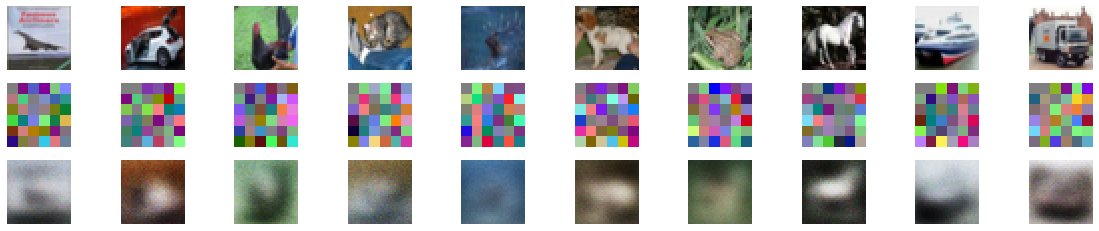

In [24]:
predict_test()

In [25]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    
    plt.plot(epochs, loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

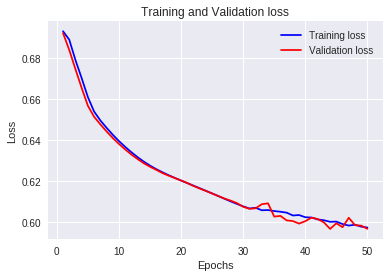

In [26]:
plot_history(history)

In [27]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
decoded_imgs.shape

(10000, 3072)

In [28]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(x_test, decoded_imgs)
print(mse)

0.019172885


In [34]:
x_test[1].mean(axis=0)

0.6082759

In [35]:
decoded_imgs[1].mean(axis=0)

0.5559898

In [29]:
%load_ext version_information
%version_information keras, tensorflow, numpy , matplotlib

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.10.0 38 generic x86_64 with debian stretch sid
keras 2.1.3
tensorflow 1.4.1
numpy 1.14.0
matplotlib 2.1.2
Mon Jan 29 22:39:53 2018 CST